In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.api import VAR
import os
import statsmodels.formula.api as smf
import math
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
from pypfopt.efficient_frontier import EfficientCVaR
import warnings
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize, Bounds, LinearConstraint

In [2]:
# The option below will force the print command to display all of the columns requested 
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [3]:
# 6 ETFs selected for porfolio diversification 

# Date AGG DIA IEO ONEQ VEA vgsix
# adjusted close for all
# AGG (ishares Core-US Aggregate Bond ETF) - Bond market
# DIA Dow SPDR etf
# ONEQ NASDAQ Fidelity etf
# IEE (ishares US oil & Gas Exploration)   - Energy market
# VEA was added to include international stocks from developed-market stocks
# vgsix Realestate Vanguard etf

# Define the ticker list
tickers_list = ['DIA', 'VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA'] 

# Fetch the monthly data of Ajusted close price for all:

df= yf.download(tickers_list, start= datetime(2004,1,1), end = datetime(2023,2,1),interval='1mo')['Adj Close']
# Save the data frame to an Excel file
df.to_excel('yahoo_data.xlsx', index=False)

etf5_data = df.dropna()

[*********************100%***********************]  6 of 6 completed


In [4]:
########## In the following chunks, we will conduct the Data Exploration ###############

In [5]:

# Find the summary statistics for all data 
Data_summary = etf5_data.describe()
print(f'Data_summary:\n{Data_summary}\n')

# Find the correlation coeficients for all data 
Corr_coef = etf5_data.corr()
print(f'Corr_coef:\n{Corr_coef}\n')

# Check number of observations
T = len(etf5_data)
print(f'T: \n{T}\n')

Data_summary:
              AGG         DIA         IEO        ONEQ         VEA       VGSIX
count  186.000000  186.000000  186.000000  186.000000  186.000000  186.000000
mean    89.546650  169.419515   52.628971   21.700437   31.526651   18.957140
std     13.149418   85.816393   14.319705   14.883861    7.989207    7.498260
min     63.406891   51.068001   20.308857    4.712527   14.021497    4.564578
25%     80.066595   94.434427   44.671216    9.607112   25.774920   12.523996
50%     90.767952  148.596519   51.574554   17.332067   30.939754   19.548559
75%     96.272360  235.976612   59.424888   29.037945   36.927370   23.705092
max    112.691200  353.846924   98.991119   60.115421   49.778748   36.853909

Corr_coef:
            AGG       DIA       IEO      ONEQ       VEA     VGSIX
AGG    1.000000  0.879437  0.076666  0.868871  0.809238  0.908792
DIA    0.879437  1.000000  0.297406  0.979107  0.943149  0.961339
IEO    0.076666  0.297406  1.000000  0.214530  0.366715  0.326764
ONEQ   0

In [6]:
# New dataframe starts from August, 2007 to Dec, 2022 (2006-06-01 to 2023-01-01) i.e around 15.5 yrs
# Total of 186 observations

In [7]:
############### Next, we will perform DATA Preprocessing for analysis and modeling purposes ##########################

In [8]:
#Setting Index
etf5_data.index = pd.date_range(start='2007-08',periods=T,freq='M')

# Create a trend variable and add to the data
trend = [i + 1 for i in range(0, len(etf5_data))]
etf5_data['trend'] = np.reshape(trend, (len(trend), 1))

In [9]:
# It should be noted that much financial timeseries data are non-stationary.
# Before any analysis it is a good idea to plot the data, test for unit roots, and probably 
# construct the log-differences in the data to obtain % return that are almost always stationary.
# In the code below, I have constructed the log-differenced data for the etf funds.

# calculate return as the log difference:
etf5s_data = etf5_data[['DIA', 'VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA']]
etf5s_data.index = pd.date_range(start='2007-08',periods=T,freq='M')
etf5s_ld_data = np.log(etf5_data[['DIA', 'VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA']]).diff(periods=1).dropna()

# Normalising data for plotting purposes
# Normalising data allows for comparison of the relative performance of the ETFs over time
etf5n_data = df.dropna()
etf5n_data['DIA'] = etf5n_data['DIA'].to_numpy() / etf5n_data['DIA'].to_numpy()[0]
etf5n_data['VGSIX'] = etf5n_data['VGSIX'].to_numpy() / etf5n_data['VGSIX'].to_numpy()[0]
etf5n_data['AGG'] = etf5n_data['AGG'].to_numpy() / etf5n_data['AGG'].to_numpy()[0]
etf5n_data['IEO'] = etf5n_data['IEO'].to_numpy() / etf5n_data['IEO'].to_numpy()[0]
etf5n_data['ONEQ'] = etf5n_data['ONEQ'].to_numpy() / etf5n_data['ONEQ'].to_numpy()[0]
etf5n_data['VEA'] = etf5n_data['VEA'].to_numpy() / etf5n_data['VEA'].to_numpy()[0]

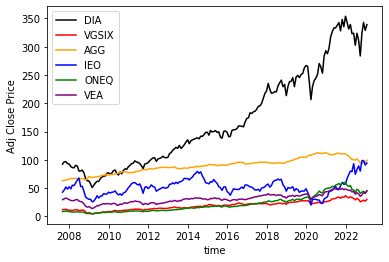

In [10]:
# We will now plot the graphs to see the trend in values of ETFs.

# Time series plot of original adjusted closing prices:
plt.plot(etf5_data.index, etf5_data['DIA'], color='black', linestyle='-', label='DIA')
plt.plot(etf5_data.index, etf5_data['VGSIX'], color='red', linestyle='-', label='VGSIX')
plt.plot(etf5_data.index, etf5_data['AGG'], color='orange', linestyle='-', label='AGG')
plt.plot(etf5_data.index, etf5_data['IEO'], color='blue', linestyle='-', label='IEO')
plt.plot(etf5_data.index, etf5_data['ONEQ'], color='green', linestyle='-', label='ONEQ')
plt.plot(etf5_data.index, etf5_data['VEA'], color='purple', linestyle='-', label='VEA')
plt.ylabel('Adj Close Price')
plt.xlabel('time')
plt.legend()
plt.savefig('etf_5_plot.pdf')
plt.show()
plt.close()

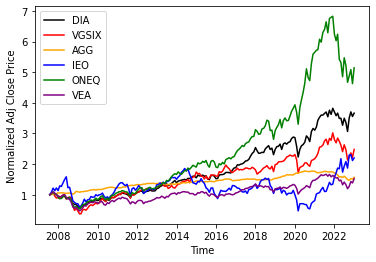

In [11]:
# Plotting Normalised data
# Time series plot of normalized adjusted closing prices with legend:
plt.plot(etf5n_data.index, etf5n_data['DIA'], color='black', linestyle='-', label='DIA')
plt.plot(etf5n_data.index, etf5n_data['VGSIX'], color='red', linestyle='-', label='VGSIX')
plt.plot(etf5n_data.index, etf5n_data['AGG'], color='orange', linestyle='-', label='AGG')
plt.plot(etf5n_data.index, etf5n_data['IEO'], color='blue', linestyle='-', label='IEO')
plt.plot(etf5n_data.index, etf5n_data['ONEQ'], color='green', linestyle='-', label='ONEQ')
plt.plot(etf5n_data.index, etf5n_data['VEA'], color='purple', linestyle='-', label='VEA')
plt.ylabel('Normalized Adj Close Price')
plt.xlabel('Time')
plt.legend()
plt.savefig('etf_normalised_plot_legend.pdf')
plt.show()
plt.close()

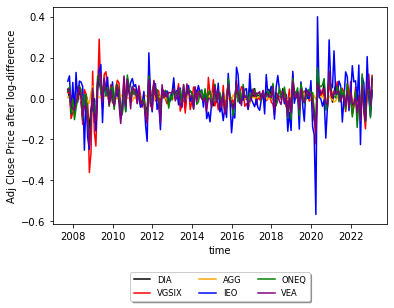

In [12]:
# Plotting Log-differenced data
# Time series plot of log-differenced adjusted closing prices with legend:
plt.plot('DIA', data=etf5s_ld_data, color='black', linestyle='-', label='DIA')
plt.plot('VGSIX',data=etf5s_ld_data, color='red', linestyle='-', label='VGSIX')
plt.plot('AGG',data=etf5s_ld_data, color='orange', linestyle='-', label='AGG')
plt.plot('IEO',data=etf5s_ld_data,color='blue', linestyle='-', label='IEO')
plt.plot('ONEQ',data=etf5s_ld_data,color='green',linestyle='-', label='ONEQ')
plt.plot('VEA',data=etf5s_ld_data,color='purple',linestyle='-', label='VEA')
plt.ylabel('Adj Close Price after log-difference')
plt.xlabel('time')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fancybox=True, shadow=True, fontsize='small')
plt.savefig('etf_5_plot_logdifference.pdf')
plt.show()
plt.close()


In [13]:
# As you can see from above plot, by taking log difference we have have mad the data stationary. 
# We will confirm this by conducting the Augmented Dickey Fuller Test below:

In [14]:
#Test for Unit Root/Stationarity:
print('\n ADF TEST TO TEST FOR UNIT ROOT/STATIONARITY\n')
result = adfuller(etf5s_ld_data['DIA'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


#The unit root test should be conducted before using the VAR as the VAR model assumes that the time series variables are stationary.



 ADF TEST TO TEST FOR UNIT ROOT/STATIONARITY

ADF Statistic: -10.697587
p-value: 0.000000


In [15]:
# Since the p-value is less than a chosen significance level (e.g., 0.05), 
# then we can reject the null hypothesis and conclude that the time series is stationary.

In [16]:
##################################### VAR MODEL APPLICATION BELOW ####################################

## We are interested in modeling a T×K multivariate time series Y, 
# where T denotes the number of observations and K the number of variables.
# One way of estimating r/n between the time series and their lagged values is the Vector Autoregression Process:
# Yt = ν + A1 Yt−1 + … + Ap Yt−p + ut  where ut∼Normal(0,Σu) and A is a K×K coefficient matrix.

# Make a VAR model - Vector Autoregression Model
# VAR(p) processes

var_model = VAR(etf5s_ld_data)

# Lag order selection
# Choice of lag order can be a difficult problem. 
# Standard analysis employs likelihood test or information criteria-based order selection. 
# We have implemented the latter, accessible through the VAR class:

# When calling the fit function, one can pass a maximum number of lags 
# and the order criterion to use for order selection:
# The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.
var_model.select_order(12)
results = var_model.fit(maxlags=12, ic='aic')
print(f'results.summary():\n{results.summary()}\n')

results.summary():
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Apr, 2023
Time:                     16:20:42
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -40.1929
Nobs:                     184.000    HQIC:                  -40.6293
Log likelihood:           2240.75    FPE:                1.68202e-18
AIC:                     -40.9268    Det(Omega_mle):     1.34443e-18
--------------------------------------------------------------------
Results for equation DIA
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.007554         0.003604            2.096           0.036
L1.DIA           0.078441         0.186304            0.421           0.674
L1.VGSIX        -0.025480         0.078406           -0.325    

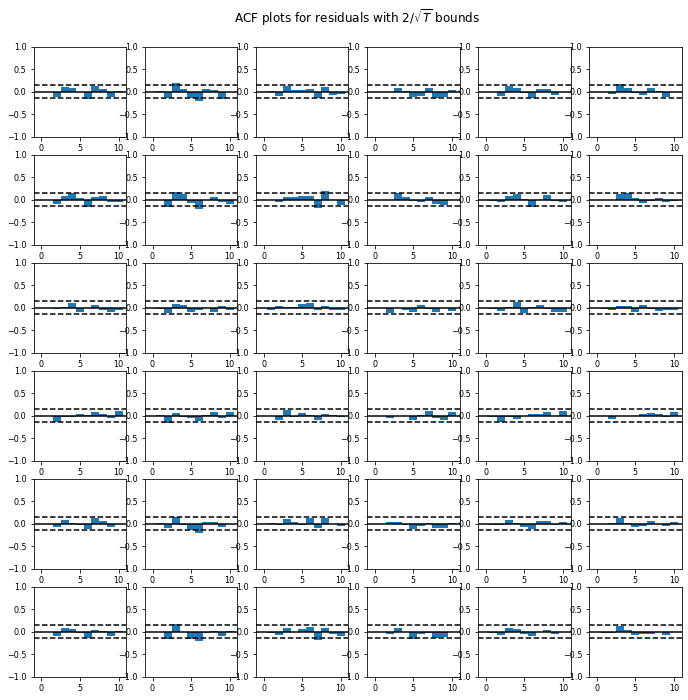

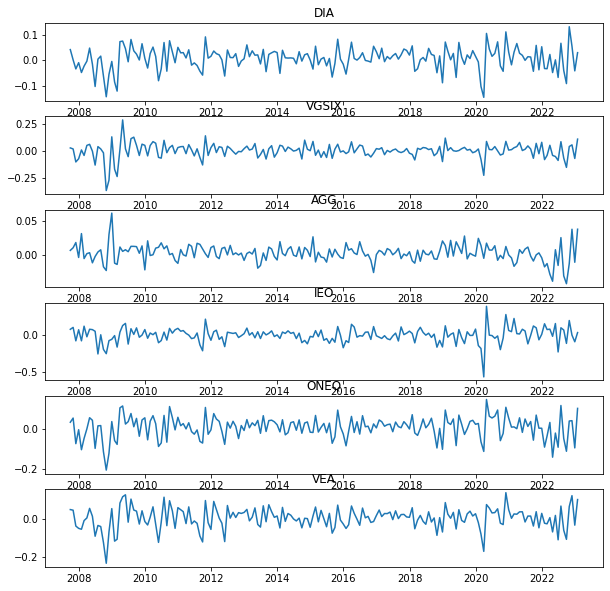

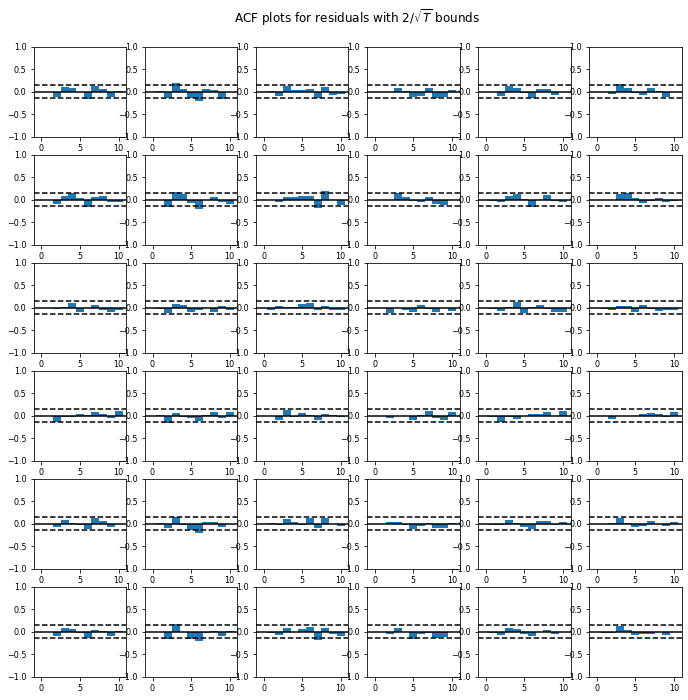

In [17]:
# Thus, the Optimal lag order = 1 in this case

# Plotting ACF and forecast results below: 
results.plot()
results.plot_acorr()


In [18]:
# ACF plots suggest no significant autocorrelation remaining in the residuals of the VAR model after fitting the model. 
# This suggests that the model has effectively captured the dependence structure between the variables. 

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

# Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).
# So, checking for serial correlation is to ensure that the model is sufficiently able to explain the 
# variances and patterns in the time series.
# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

out = durbin_watson(results.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

AGG : 2.01
DIA : 1.98
IEO : 2.08
ONEQ : 2.02
VEA : 2.02
VGSIX : 2.02


In [19]:
#The serial correlation seems quite alright as all are around 2. Let’s proceed with the forecast.

In [20]:
# Forecasting
# The linear predictor is the optimal h-step ahead forecast in terms of mean-squared error:
# yt(h) = ν + A1 yt(h−1) + ⋯ + Ap yt(h−p)

# We can use the forecast function to produce this forecast. 
# Note that we have to specify the “initial value” for the forecast:
print('\n')
lag_order = results.k_ar
forecast = results.forecast(etf5s_ld_data.values[-lag_order:], 12)
print(f'forecast:\n{forecast}\n')



forecast:
[[ 0.00189742 -0.00089087 -0.00244308 -0.00655572  0.02670509  0.00131781]
 [ 0.00604342  0.00020296  0.00044237  0.00419552  0.00656487 -0.00197165]
 [ 0.00681562  0.00450145  0.00239082  0.00375575  0.00750811  0.00158757]
 [ 0.00686265  0.00485037  0.00247177  0.00396415  0.00877525  0.00216766]
 [ 0.00678841  0.00468726  0.00238701  0.00374793  0.00881043  0.00202188]
 [ 0.0067888   0.00465566  0.00237671  0.00377407  0.00876606  0.00198519]
 [ 0.00678928  0.0046595   0.00237941  0.00377002  0.00875645  0.00198613]
 [ 0.00679006  0.00466151  0.00238031  0.00377241  0.0087585   0.00198843]
 [ 0.0067899   0.0046615   0.00238025  0.00377169  0.00875894  0.00198847]
 [ 0.0067899   0.00466141  0.00238021  0.00377179  0.00875895  0.0019884 ]
 [ 0.0067899   0.0046614   0.00238021  0.00377175  0.00875891  0.00198838]
 [ 0.0067899   0.0046614   0.00238021  0.00377177  0.00875891  0.00198838]]



In [21]:
# Averaging forecast for 12 months:

forecast1 = pd.DataFrame(data = forecast, columns = ["DIA",
                                   "VGSIX", "AGG", "IEO", "ONEQ", "VEA"])

#forecast.columns =['DIA','VGSIX','AGG','IEO ','ONEQ','VEA']

print('12 Month returns:')
print('  DIA          VGSIX        AGG        IEO        ONEQ        VEA')
print(np.sum(forecast, axis=0))

df= pd.DataFrame(np.sum(forecast, axis=0))
forecast2= df.transpose()
forecast2.columns =['DIA','VGSIX','AGG','IEO ','ONEQ','VEA']

12 Month returns:
  DIA          VGSIX        AGG        IEO        ONEQ        VEA
[0.07593525 0.04597355 0.02190621 0.03551111 0.11968048 0.01903666]


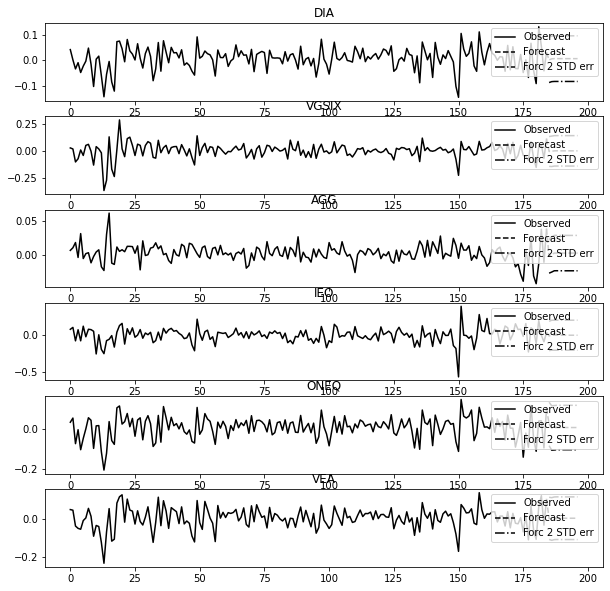

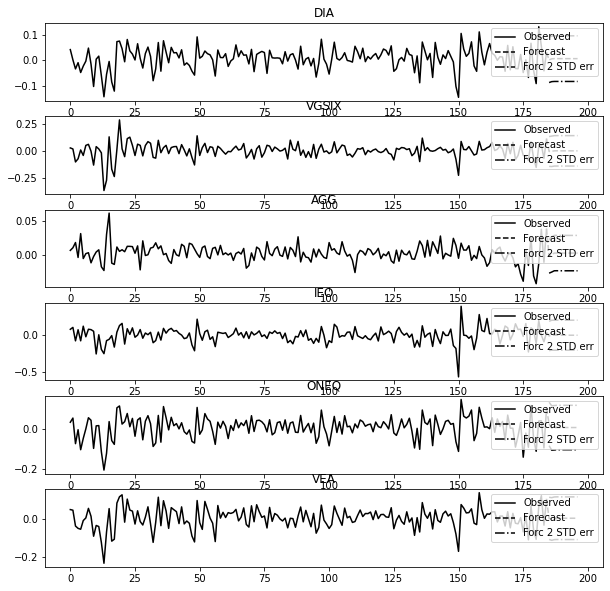

In [22]:
# Extract correlation matrix from VAR model results
residuals = results.resid
corr_matrix  = residuals.corr()

# Save correlation matrix as CSV file
corr_matrix.to_csv('corr_matrix.csv')

# The forecast_interval function will produce the above forecast along with asymptotic standard errors. 
# These can be visualized using the plot_forecast function:
results.plot_forecast(12)

++++++++++ Impulse Analysis++++++++++++++++++


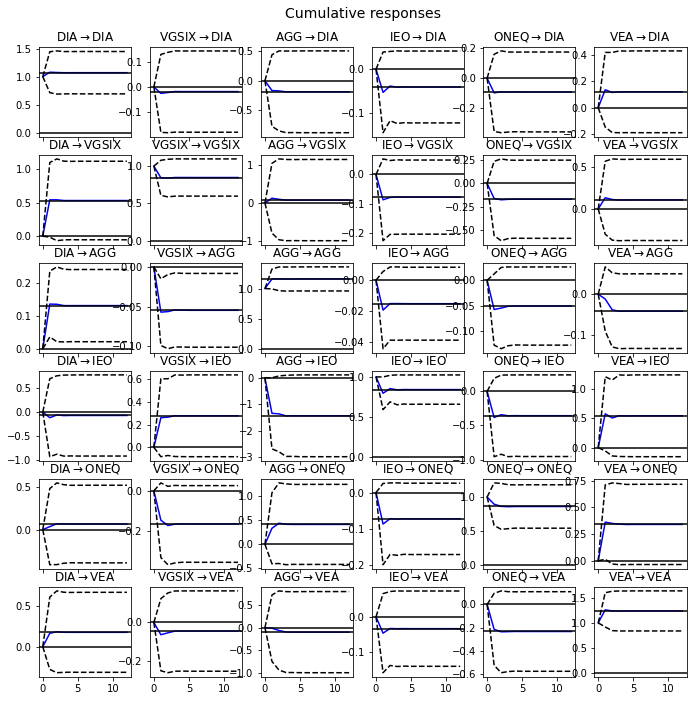

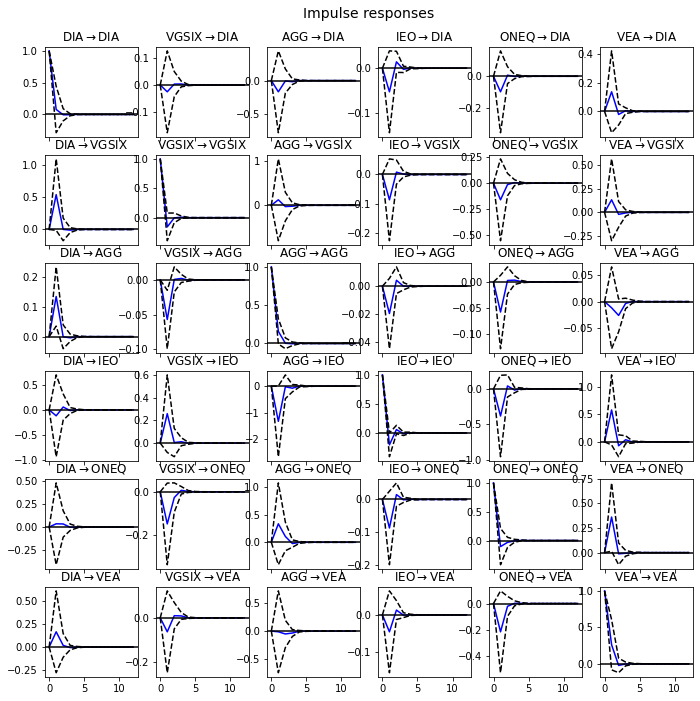

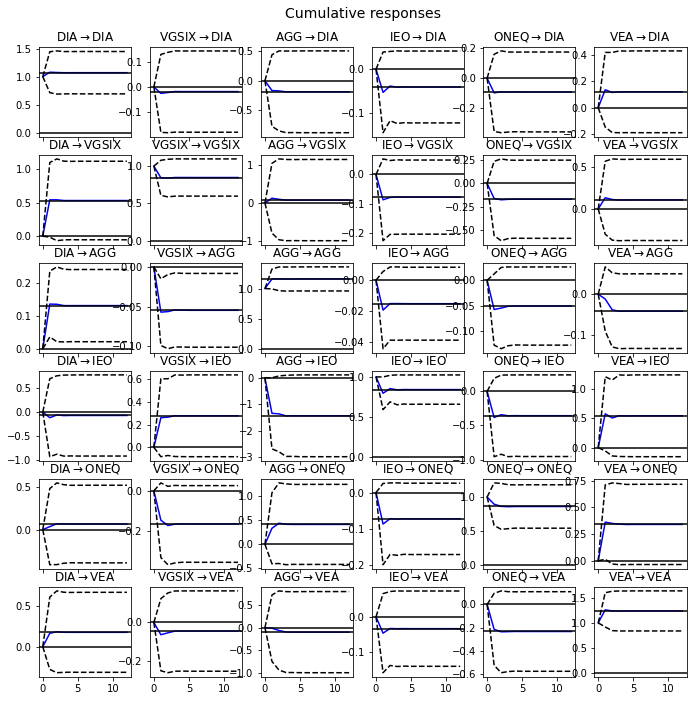

In [23]:
################### Impulse Response Analysis
# Impulse responses are of interest in econometric studies: 
#    they are the estimated responses to a unit impulse in one of the variables. 
# They are computed in practice using the MA(∞) representation of the VAR(p) process:
# Yt = μ + ∑i=0 to ∞ Φi ut−i

# We can perform an impulse response analysis by calling the irf function on a VARResults object:
# These can be visualized using the plot function, in either orthogonalized or non-orthogonalized form. 
# Asymptotic standard errors are plotted by default at the 95% significance level, which can be modified by the user.   



print('++++++++++ Impulse Analysis++++++++++++++++++')
irf = results.irf(12)
irf.plot(orth=False)

# The cumulative effects Ψn=∑ni=0Φi can be plotted with the long run effects as follows:
irf.plot_cum_effects(orth=False)

In [24]:
#IRA shows that there are some significant responses to the shock of each variable on itself and on the other variables in the system.
# This suggests that the variables in the system have significant impacts on each other, and there are some dynamic interconnections between them

In [25]:
# Granger causality
# One is often interested in whether a variable or group of variables is “causal” for another variable, 
# for some definition of “causal”. In the context of VAR models, 
# one can say that a set of variables are Granger-causal within one of the VAR equations. 
# The VARResults object has the test_causality methodfor performing either a Wald (χ2) test or an F-test.

['DIA', 'VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA']
print('\n')
print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for DIA')
print(results.test_causality('DIA', ['VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA'], kind='f'))
print('\n')

print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for VGSIX')
print(results.test_causality('VGSIX', ['DIA', 'AGG', 'IEO', 'ONEQ', 'VEA'], kind='f'))
print('\n')

print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for AGG')
print(results.test_causality('AGG', ['VGSIX', 'IEO', 'ONEQ', 'VEA'], kind='f'))
print('\n')

print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for IEO')
print(results.test_causality('IEO', ['VGSIX', 'AGG', 'ONEQ', 'VEA'], kind='f'))
print('\n')

print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for ONEQ')
print(results.test_causality('ONEQ', ['VGSIX', 'IEO', 'AGG', 'VEA'], kind='f'))
print('\n')

print('+++++++++++++++++++++++++++++++++++')
print('Test for Granger causality for VEA')
print(results.test_causality('VEA', ['VGSIX', 'IEO', 'AGG', 'ONEQ'], kind='f'))
print('\n')



+++++++++++++++++++++++++++++++++++
Test for Granger causality for DIA
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['VGSIX', 'AGG', 'IEO', 'ONEQ', 'VEA'] do not Granger-cause DIA: fail to reject at 5% significance level. Test statistic: 0.433, critical value: 2.223>, p-value: 0.826>


+++++++++++++++++++++++++++++++++++
Test for Granger causality for VGSIX
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['DIA', 'AGG', 'IEO', 'ONEQ', 'VEA'] do not Granger-cause VGSIX: fail to reject at 5% significance level. Test statistic: 1.475, critical value: 2.223>, p-value: 0.195>


+++++++++++++++++++++++++++++++++++
Test for Granger causality for AGG
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['VGSIX', 'IEO', 'ONEQ', 'VEA'] do not Granger-cause AGG: reject at 5% significance level. Test statistic: 4.233, critical value: 2.380>, p-value: 0.002>


++++++++++++++++++++++++++++++

In [26]:
# There is causality between these series, which shows, VAR model is a good fit for this data.

In [27]:
# Normality

print('\n')
print('+++++++++++++++++++++++++++++++++++')
print(results.test_normality())



+++++++++++++++++++++++++++++++++++
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 150.760, critical value: 21.026>, p-value: 0.000>


In [28]:
# The white noise component ut is assumed to be normally distributed. 
# While this assumption is not required for parameter estimates to be consistent or asymptotically normal, 
# results are generally more reliable in finite samples when residuals are Gaussian white noise. 
# To test whether this assumption is consistent with a data set, VARResults offers the test_normality method.
# Note: Stock market return data are frequently NOT normally distributed!

In [29]:
#############################################################################################################

################################ PORTFOLIO OPTIMIZATION #####################################


# Setting up dataframe 
portfolio = etf5_data.drop("trend", axis='columns')

# Load data and extract expected returns from VAR model forecast

# Define objective function to minimize portfolio risk
def portfolio_vol(weights, corr_matrix):
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(corr_matrix, weights)))
    return port_volatility

# Define constraints for optimization
def portfolio_weights(weights):
    return weights.sum() - 1

In [30]:
# The optimization problem is then solved using the SLSQP method from the scipy module.

# Set up optimization problem
num_assets = len(etf5s_data.columns)
initial_weights = np.array(num_assets * [1.0 / num_assets])
corr_matrix = residuals.corr()
target_return = forecast2.iloc[0].values

# Minimize portfolio risk subject to constraints
bounds = tuple((0, 1) for i in range(num_assets))
constraints = ({'type': 'eq', 'fun': portfolio_weights})
optimized = minimize(portfolio_vol, initial_weights, args=(corr_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Print results
print('Optimized Weights:', optimized.x)
print('Portfolio Return:', np.dot(optimized.x, target_return))
print('Portfolio Volatility:', portfolio_vol(optimized.x, corr_matrix))


Optimized Weights: [1.08261871e-01 7.15573434e-18 4.56420314e-01 3.77252890e-01
 5.80649248e-02 6.50521303e-18]
Portfolio Return: 0.03856523868715149
Portfolio Volatility: 0.678291894196999


In [31]:
#In this case, the optimized portfolio has a return of 0.0386 and a volatility of 0.6783. 


In [32]:
forecast_names = forecast2.columns.tolist()
weights_dict = dict(zip(forecast_names, optimized.x))
print(weights_dict)

{'DIA': 0.1082618709825781, 'VGSIX': 7.15573433840433e-18, 'AGG': 0.45642031447950726, 'IEO ': 0.3772528897110492, 'ONEQ': 0.058064924826865386, 'VEA': 6.5052130349130266e-18}


In [33]:
# The optimized weights suggest that the portfolio should invest in DIA with a weight of 0.108,
# AGG with a weight of 0.456, IEO with a weight of 0.377, ONEQ with a weight of 0.058,
# and no investment in VEA and VGSIX.

In [34]:

## Plotting Efficient Frontier Below:

##########################################Plotting###################################

# Generate range of target returns
n_points = 20
min_return = np.min(target_return)
max_return = np.max(target_return)
target_returns = np.linspace(min_return, max_return, n_points)

# Optimize portfolio for each target return
portfolios = []
for tr in target_returns:
    constraints = ({'type': 'eq', 'fun': portfolio_weights},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, target_return) - tr})
    opt = minimize(portfolio_vol, initial_weights, args=(corr_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    portfolios.append(opt)


In [35]:
# Extract results
port_volatilities = [portfolio_vol(p.x, corr_matrix) for p in portfolios]
port_returns = [np.dot(p.x, target_return) for p in portfolios]

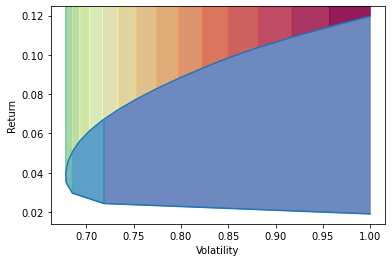

In [36]:
# Plot efficient frontier
fig, ax = plt.subplots()
ax.plot(port_volatilities, port_returns)

# Add color to the plot
y_min, y_max = ax.get_ylim()
color_scale = plt.cm.Spectral_r(np.linspace(0, 1, n_points))
for i in range(n_points - 1):
    polygon = plt.Polygon(np.array([[port_volatilities[i], port_returns[i]],
                                     [port_volatilities[i+1], port_returns[i+1]],
                                     [port_volatilities[i+1], y_max],
                                     [port_volatilities[i], y_max]]),
                          facecolor=color_scale[i+1],
                          edgecolor=color_scale[i+1],
                          alpha=0.8)
    ax.add_patch(polygon)

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
#plt.title('Efficient Frontier')
plt.show()



In [37]:
# This completes the project.
# Both VAR modelling and portfolio optimization using scipy were used to make predictions and optimize the portfolio.
# Thank you !